# Initialize

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import pickle
from IPython.display import display, Math
from matplotlib.ticker import StrMethodFormatter, PercentFormatter
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import shift
from scipy.constants import c, pi
from pandas import DataFrame

import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.backend.operators import compute_velocity, compute_position, compute_objective_function
from pyswarms.backend.handlers import VelocityHandler, BoundaryHandler

from tqdm.notebook import tqdm  # Needs installation of jupyter and ipywidgets packages

import sys
sys.path.append('../../python')

from Functions import *
from Classes import *

versions = ['v202','v221','v231','v242']  # Lumerical versions in this scope

try:
    print('imp module found!')
    import imp
    for ver in versions:
        try:
            os.add_dll_directory('C:\\Program Files\\Lumerical\\'+ ver +'\\api\\python\\')
            lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\'+ ver +'\\api\\python\\lumapi.py')
            print(f'version {ver} found!')
            break
        except:
            print(f'version {ver} not found...')

except:
    print('imp module not found. Trying with importlib...')
    from importlib.machinery import SourceFileLoader
    print('found!')
    for ver in versions:
        try:
            os.add_dll_directory('C:\\Program Files\\Lumerical\\'+ ver +'\\api\\python\\')
            lumapi = SourceFileLoader('lumapi','C:\\Program Files\\Lumerical\\'+ ver +'\\api\\python\\lumapi.py').load_module()
            print(f'version {ver} found!')
            break
        except:
            print(f'version {ver} not found...')

from lumapi import LumApiError

plt.rcParams["figure.figsize"] = (8,6) 
plt.rc('font', size=12)

imp module found!
version v202 found!


C:\Users\Caio\AppData\Local\Temp\ipykernel_20276\729811833.py:10: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [10]:
# inter = lumapi.INTERCONNECT(filename='../../../simulation/files/pnn/AnalysisPNN.icp')
inter = lumapi.INTERCONNECT(filename='../../../simulation/files/pnn/pyswarmTesting.icp')
# inter = lumapi.INTERCONNECT()

Exception ignored in: <function Lumerical.__del__ at 0x000001ECFF74A820>
Traceback (most recent call last):
  File "C:\Program Files\Lumerical\v202\api\python\lumapi.py", line 1179, in __del__
    close(self.handle)
  File "C:\Program Files\Lumerical\v202\api\python\lumapi.py", line 252, in close
    iapi.appClose(handle)
ctypes.ArgumentError: argument 1: <class 'TypeError'>: expected Session instance instead of Session


# Parallel Model

In [11]:
PNNPSO = PNN(DelayUnitLen=811e-6,unitsNextTap=4,WvgLoss=591.86)
PNNPSO.transmission(FiberLen=10e3,PulseAmp=2,PRBSType='PRBS',MZMILoss=0,RiseTime=0.1,FallTime=0.1,ToggleBitOp=True)
PNNPSO.simulation(bitrate=16e9,timeWindow=5.12e-9*128/4,numofSamples=65536*2)
PNNPSO.output(OutputType='mixed',ToggleAWGN=False,ToggleOptFilter=True)
PNNPSO.photoreceptor(PDResponsivity=0.9,PDDarkCurrent=50e-9,TogglePDSNoise=True)
PNNPSO.showParameters()

print(f'Number of Bits = {PNNPSO.getAttributes("bitrate")[0]*PNNPSO.getAttributes("timeWindow")[0]}')
print(f'Samples per Bits = {(PNNPSO.getAttributes("numofSamples")[0] / (PNNPSO.getAttributes("bitrate")[0]*PNNPSO.getAttributes("timeWindow")[0]))}')

general :: Model: parallel | Taps: 4 | Delay Unit Length: 8.11e-10 μm | Units for next tap: 4 | Wvg Loss: 591.86 dB/m
transmission :: Fiber length: 10.0 km | PRBS Type: PRBS | Pulse Amplitude: 2 | Rise/Fall Period: 0.1/0.1 | MZM Insetion Loss: 0 dB
simulation :: Bit Rate: 16.0 Gbits/s | Number of Samples: 131072 | Time Window: 1.6384e-07 s
photoreceptor :: PD Responsivity: 0.9 A/W | PD Dark Current: 5e-08 A | PD Thermal Noise: 1e-22 A/Hz^.5
output :: AWGN PSD: 2e-20 W/Hz | Optical Filter bandwidth: 25.0 GHz
-----------------------------------------------------------------------------------
XOR Operator: enabled
PD Thermal Noise: disabled
PD Shot Noise: enabled
AWGN post PD: disabled
Optical Filter: enabled
Output Type: mixed
Number of Bits = 2621.44
Samples per Bits = 50.0


In [20]:
PNNPSO.mount(inter)

## Pyswarms Library

Making the PSO algorithm using the Pyswarms library

### Training (Agent Parallel)

In [12]:
samplespBit = 16*2 # Choosing Samples per bit
# numberOfBits = 1048*16 # Choosing number of bits
numberOfBits = 1048*2 # Choosing number of bits

# Choosing "Samples per Bit" and "Number of Bits" prior the "time window" and "number of samples" 
# avoid de'cimals and hence, avoid errors regarding different array sizes on simulations wiht large number of samples.

# PNNPSO.output(NoisePSD=1e-20)
PNNPSO.simulation(bitrate=16e9,numofSamples=samplespBit*numberOfBits)
timeWindow = PNNPSO.getAttributes("numofSamples")[0] / (PNNPSO.getAttributes("bitrate")[0]*samplespBit)
PNNPSO.simulation(timeWindow=timeWindow)
PNNPSO.update(inter)

print(f'number of samples = {PNNPSO.getAttributes("numofSamples")[0]}')
print(f'samples per bit = {samplespBit}')
print(f'time Window = {PNNPSO.getAttributes("timeWindow")[0]*1e9} ns')
print(f'bits = {PNNPSO.getAttributes("numofSamples")[0]/samplespBit}')

cutMargin = 8  # Signal cutting. This is valid for training purposes.

agents = 5  # Number of agents
gens = 10    # Max number of gens per agent
pars = 3     # Arm B, C, D
bounds = (np.zeros(pars), np.full(pars, 2*np.pi))
options = {'c1': 0.3, 'c2': 0.3, 'w': 0.5}

mydir = "../../../simulation/files/pnn/"
myfolder = 'pyswarmTesting_AgentSweep'

# PSD Sweep object creation ----------------------------------------

def recreateAgentSweep(inter,agents,mydir,myfolder):

    path = os.path.join(mydir, myfolder)

    # If directory exists, delete it.
    if os.path.isdir(mydir+myfolder): shutil.rmtree(path, ignore_errors=False)
    else: print("%s directory not found" % {mydir+myfolder})

    inter.deletesweep('AgentSweep')
    inter.addsweep(0)
    inter.setsweep('sweep','name','AgentSweep')
    inter.setsweep('AgentSweep','type','Values')
    inter.setsweep('AgentSweep','number of points',agents)

    ArmBParam = {'Name':'ArmB','Parameter':'::Root Element::IDEAL_CELL_5::Common Theta',  'Type':'Number'}
    ArmCParam = {'Name':'ArmC','Parameter':'::Root Element::IDEAL_CELL_6::Common Theta',  'Type':'Number'}
    ArmDParam = {'Name':'ArmD','Parameter':'::Root Element::IDEAL_CELL_7::Common Theta',  'Type':'Number'}
    for i in range(agents):
        param = 'Value_'+str(i+1)
        ArmBParam[param] = 0
        ArmCParam[param] = 0
        ArmDParam[param] = 0
    inter.addsweepparameter('AgentSweep',ArmBParam)
    inter.addsweepparameter('AgentSweep',ArmCParam)
    inter.addsweepparameter('AgentSweep',ArmDParam)

    OSC3Result = {'Name':'OSC3_Result','Result':'::Root Element::OSC_2::signal'}
    # SignalPower = {'Name':'Signal_Power','Result':'::Root Element::Signal_Power::total power'}
    # NoisePower = {'Name':'Noise_Power','Result':'::Root Element::Noise_Power::total power'}
    DigitalSignal = {'Name':'Digital_Signal','Result':'::Root Element::LGCA_4::digital signal'}
    inter.addsweepresult('AgentSweep',OSC3Result)
    # inter.addsweepresult('AgentSweep',SignalPower)
    # inter.addsweepresult('AgentSweep',NoisePower)
    inter.addsweepresult('AgentSweep',DigitalSignal)

number of samples = 67072
samples per bit = 32
time Window = 131.0 ns
bits = 2096.0


In [23]:
LoadCheckpoint = 0 # ID for checkpoint file to be loaded. Put 0 to load nothing.
if LoadCheckpoint != 0: print(f'Checkpoint {LoadCheckpoint} loaded')
else: print(f'No checkpoint loaded')

picklepath = '../../../data/Checkpoints/PNN_Results/ParallelModel/AgentParallel_Training/'
checkpoint_count = sum(len(files) for _, _, files in os.walk(picklepath))
SaveFile = {}

PSDminBER = 1
OptThreshold = 0
OptSampPos = 1

# Handlers for out-of-bounds agents
vh = VelocityHandler(strategy="unmodified")      # Handler for velocity
bh = BoundaryHandler(strategy="reflective")      # Handler for position

# Objective function ---------------------------------------------------------
def objective_function(Signal, Reference):
    AgentminBER = np.full(agents, 0.5)  # Max BER initialization
    BestThresholds = np.zeros(agents)
    BestSamplings = np.zeros(agents)

    global PSDminBER, OptThreshold, OptSampPos

    for j in range(agents):
        OSCPower = Signal['amplitude (a.u.)'][int(cutMargin*samplespBit):int(-cutMargin*samplespBit), j]
        LGCAbit = np.repeat(Reference['amplitude (a.u.)'][::2, j], samplespBit)
        
        ThreArray = np.linspace(np.max(OSCPower), (np.min(OSCPower) > 0) * np.min(OSCPower), 200)
        delayArray = np.floor(np.linspace(0, samplespBit-1, samplespBit)).astype(int)
        
        corMax = np.argmax(np.correlate(OSCPower, LGCAbit, mode='full'))

        SampBERarray = np.zeros(samplespBit)
        ThreBERarray = np.zeros(len(ThreArray))
        SampOptIdx = np.zeros(len(ThreArray))

        for k in range(len(ThreArray)):
            Threshold = ThreArray[k]

            for m in range(samplespBit):
                if corMax < len(LGCAbit):
                    sampRef = LGCAbit[int(len(LGCAbit) - corMax + delayArray[m]):]
                    sampOut = OSCPower[delayArray[m]:]
                else:
                    sampRef = LGCAbit[delayArray[m]:]
                    sampOut = OSCPower[int(corMax - len(LGCAbit) + delayArray[m]):]

                sampRef = sampRef[::samplespBit]
                sampOut = sampOut[::samplespBit]

                minIdx = min(len(sampRef), len(sampOut))
                transformed = (sampOut[:minIdx] >= Threshold).astype(int)
                errors = np.logical_xor(sampRef[:minIdx], transformed[:minIdx])
                count = np.sum(errors)
                SampBERarray[m] = 0.5 - abs(0.5 - count / minIdx)

            ThreBERarray[k] = np.min(SampBERarray)
            SampOptIdx[k] = np.argmin(SampBERarray) + 1

            # Atualiza global
            if ThreBERarray[k] < PSDminBER:
                PSDminBER = ThreBERarray[k]
                OptSampPos = int(SampOptIdx[k])
                OptThreshold = ThreArray[k]

        AgentminBER[j] = np.min(ThreBERarray)
        BestThresholds[j] = ThreArray[int(np.argmin(ThreBERarray))]
        BestSamplings[j] = SampOptIdx[int(np.argmin(ThreBERarray))]

    return AgentminBER, BestThresholds, BestSamplings



def PSO_training(): 
    global lastgen, position_history, pbest_history, gbest_history, OptThreshold, OptSampPos, PSDminBER
    global PSDminBER, OptSampPos, OptThreshold, SNRValue, stopGen, LoadCheckpoint, Thre_history, Samp_history

    stopGen = gens  # put -1 to signalize that no previous stop was made

    AgBestThreshold = np.full(agents, np.nan) # For saving each agent optimal threshold on pbest case
    AgBestSampling = np.full(agents, np.nan)  # For saving each agent optimal sampling pos. on pbest case
 

    # Optimizer initialization ---------------------------------------------------------
    optimizer = GlobalBestPSO(n_particles=agents, dimensions=pars, options=options, bounds=bounds)
    optimizer.reset()
    swarm = optimizer.swarm
    swarm.options = options

    swarm.pbest_cost = np.full(agents, 0.5)            
    swarm.pbest_pos = swarm.position.copy()    

    swarm.best_cost = 0.5                              
    swarm.best_pos = swarm.position[np.argmin(swarm.pbest_cost)].copy()

    print(f'Agents: {agents} | generations: {gens}')

    if LoadCheckpoint != 0:
        with open(picklepath + f'Checkpoint({LoadCheckpoint}).pickle', 'rb') as handle:
            LoadFile = pickle.load(handle)
        lastgen = LoadFile['LastGen']
        swarm.position = LoadFile['parArray'].copy()
        swarm.velocity = LoadFile['velArray'].copy()
        PSDminBER = LoadFile['PSDminBER']
        OptThreshold = LoadFile['OptThreshold']
        OptSampPos = LoadFile['OptSampPos']
        Thre_history = LoadFile['ThreFollow']
        Samp_history = LoadFile['SampFollow']
        position_history = LoadFile['posEvo'].copy()
        pbest_history = LoadFile['pBestEvo'].copy()
        gbest_history = LoadFile['gBestEvo'].copy()
        pbest_pos_history = LoadFile['pBestPosEvo']
        gbest_pos_history = LoadFile['gBestPosEvo']
        swarm.pbest_cost = pbest_history[-1].copy()
        swarm.pbest_pos  = pbest_pos_history[-1].copy()
        swarm.best_cost  = gbest_history[-1].copy()
        swarm.best_pos   = gbest_pos_history[-1].copy()
        AgBestThreshold = LoadFile['BestThreshold']
        AgBestSampling  = LoadFile['BestSampling'] 
    else:
        lastgen = -1
        position_history = [swarm.position.copy()]
        pbest_history = [swarm.pbest_cost.copy()]
        gbest_history = [swarm.best_cost]
        pbest_pos_history = [swarm.pbest_pos.copy()]
        gbest_pos_history = [swarm.best_pos.copy()]
        Thre_history = np.zeros((agents, gens))
        Samp_history = np.zeros((agents, gens))


    # Optimization Loop ---------------------------------------------------------
    progress = tqdm(total=(gens - lastgen - 1))

    for i in range(lastgen + 1, gens):
        print(f'starting with gbest: {swarm.best_cost}')
        print(f'agents pbests: {swarm.pbest_cost}')

        if (np.all(np.array(pbest_history)[i-1, :] < 1/numberOfBits)) and i > 0:
            stopGen = i - 1
            break

        # Simulation Section ---------------------------------------------------------
        inter.switchtolayout()
        recreateAgentSweep(inter,agents,mydir,myfolder)

        ArmBParam = {'Name':'ArmB','Parameter':'::Root Element::IDEAL_CELL_5::Common Theta',  'Type':'Number'}
        ArmCParam = {'Name':'ArmC','Parameter':'::Root Element::IDEAL_CELL_6::Common Theta',  'Type':'Number'}
        ArmDParam = {'Name':'ArmD','Parameter':'::Root Element::IDEAL_CELL_7::Common Theta',  'Type':'Number'}
        for j in range(agents):
            param = 'Value_'+str(j+1)
            ArmBParam[param] = swarm.position[j,0]
            ArmCParam[param] = swarm.position[j,1]
            ArmDParam[param] = swarm.position[j,2]
        
        inter.setsweep('AgentSweep','ArmB',ArmBParam)
        inter.setsweep('AgentSweep','ArmC',ArmCParam)
        inter.setsweep('AgentSweep','ArmD',ArmDParam)
        inter.runsweep('AgentSweep')

        try:
            SweepOSC3 = inter.getsweepresult('AgentSweep', 'OSC3_Result')
            SweepDigital = inter.getsweepresult('AgentSweep', 'Digital_Signal')
            
            swarm.current_cost, best_thresholds, best_samplings = objective_function(SweepOSC3, SweepDigital)
            Thre_history[:, i] = best_thresholds    # Threshold value following (not restricted to pbest)
            Samp_history[:, i] = best_samplings     # Sampling pos. following (not restricted to pbest)

            mask = swarm.current_cost < swarm.pbest_cost
            swarm.pbest_cost[mask] = swarm.current_cost[mask]
            swarm.pbest_pos[mask] = swarm.position[mask]
            AgBestThreshold[mask] = best_thresholds[mask]
            AgBestSampling[mask] = best_samplings[mask]

            best_idx = np.argmin(swarm.current_cost)
            if swarm.current_cost[best_idx] < swarm.best_cost:
                swarm.best_cost = swarm.current_cost[best_idx]
                swarm.best_pos = swarm.position[best_idx].copy()
                PSDminBER = swarm.best_cost

            position_history.append(swarm.position.copy())
            pbest_history.append(swarm.pbest_cost.copy())
            gbest_history.append(swarm.best_cost.copy())
            pbest_pos_history.append(swarm.pbest_pos.copy())
            gbest_pos_history.append(swarm.best_pos.copy())

            swarm.velocity = compute_velocity(swarm, clamp=None, bounds=bounds, vh=vh)
            swarm.position = compute_position(swarm, bounds=bounds, bh=bh)

            progress.update(1)

            SaveFile = {
                'LastGen': i,
                'parArray': swarm.position,
                'velArray': swarm.velocity,
                'PSDminBER': PSDminBER,
                'OptThreshold': OptThreshold,
                'OptSampPos': OptSampPos,
                'ThreFollow': Thre_history,
                'SampFollow': Samp_history,
                'posEvo': position_history,
                'pBestEvo': pbest_history,
                'gBestEvo': gbest_history,
                'pBestPosEvo': pbest_pos_history, 
                'gBestPosEvo': gbest_pos_history,  
                'stopGen': stopGen,
                'BestThreshold': AgBestThreshold,
                'BestSampling': AgBestSampling
            }
            if LoadCheckpoint == 0:
                with open(picklepath+'Checkpoint('+str(checkpoint_count+1)+').pickle','wb') as handle:
                    pickle.dump(SaveFile,handle,protocol=pickle.HIGHEST_PROTOCOL)
            else:
                with open(picklepath+'Checkpoint('+str(LoadCheckpoint)+').pickle','wb') as handle:
                    pickle.dump(SaveFile,handle,protocol=pickle.HIGHEST_PROTOCOL)

        except Exception as e:
            import traceback

            if isinstance(e, LumApiError):
                if "has no results" in str(e) and "'AgentSweep'" in str(e):
                    print("🛑 Known Error Detected: No results in AgentSweep. Retrying.")
                    return {"status":"retry"}
                
            if isinstance(e, KeyError):
                if "'amplitude (a.u.)'" in str(e) or "amplitude (a.u.)" in str(e):
                    print("🛑 Known Error Detected:: KeyError 'amplitude (a.u.)' not present.")
                    return {"status":"retry"}
                
            raise

    return {"status":"ok",
            "pBestFollow":pbest_history, "gBestFollow":gbest_history, "pathFollow":position_history,
            "stopGen":stopGen, "ThreFollow":Thre_history, "SampFollow":Samp_history,
            "gBestPos":swarm.best_pos, "OptThreshold":OptThreshold, "OptSampPos":OptSampPos,
            "AgBestThreshold": AgBestThreshold, "AgBestSampling": AgBestSampling}


attempts = 0
while attempts <= gens:
    attempts += 1

    PSOOut = PSO_training()

    if PSOOut["status"] == "retry" and LoadCheckpoint != 0:
        print(f"⚠️ Retrying... Attempt {attempts}")
    elif PSOOut["status"] == "ok":
        break
    elif LoadCheckpoint == 0:
        if sum(len(files) for _, _, files in os.walk(picklepath)) == checkpoint_count:
            raise Exception("❗️Cannot retry if no checkpoint exists for this simulation")
        LoadCheckpoint = checkpoint_count+1
        print(f'🔃 Load Checkpoint altered to {LoadCheckpoint}')
        print(f"⚠️ Retrying... Attempt {attempts}")

if attempts > gens:
    raise Exception(f"❌ Maximum attempts reached ({gens}).")


# --- PLOTS ---

position_history = np.array(position_history)
pbest_history = np.array(pbest_history)
gbest_history = np.array(gbest_history)

plt.figure()
plt.title(f'Score History (BER)',fontsize=16, fontweight="bold")

plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True

for i in range(agents):
    plt.plot(np.arange(1,stopGen+3),pbest_history[:,i],label=f'agent {i+1} pBest')
plt.plot(np.arange(1,stopGen+3),gbest_history,linestyle='--',label=f'gBest',color='gray')
plt.xlabel('Generation')
plt.ylabel('Score (BER)')
plt.yscale('log')

plt.grid()
plt.legend()

No checkpoint loaded
Agents: 5 | generations: 10


  0%|          | 0/10 [00:00<?, ?it/s]

starting with gbest: 0.5
agents pbests: [0.5 0.5 0.5 0.5 0.5]
starting with gbest: 0.25156325156325154
agents pbests: [0.25156325 0.37391723 0.31809432 0.31809432 0.37391723]


: 

: 

In [20]:
AgBestThreshold = PSOOut['AgBestThreshold']
AgBestSampling = PSOOut['AgBestSampling']

data = {
    'Agent': np.arange(1, agents+1),
    'Best Threshold': AgBestThreshold,
    'Best Sampling': AgBestSampling
}

df = pd.DataFrame(data)

print(df)

   Agent  Best Threshold  Best Sampling
0      1        0.000102           23.0
1      2        0.000075            3.0
2      3        0.000042           12.0
3      4        0.000032           11.0
4      5        0.000056           24.0


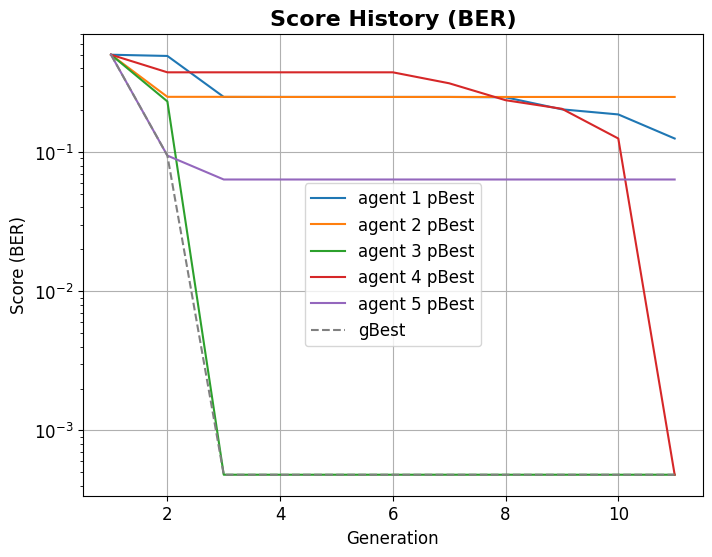

In [21]:
position_history = np.array(position_history)
pbest_history = np.array(pbest_history)
gbest_history = np.array(gbest_history)

plt.figure()
plt.title(f'Score History (BER)',fontsize=16, fontweight="bold")

plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True

for i in range(agents):
    plt.plot(np.arange(1,stopGen+2),pbest_history[:,i],label=f'agent {i+1} pBest')
plt.plot(np.arange(1,stopGen+2),gbest_history,linestyle='--',label=f'gBest',color='gray')
plt.xlabel('Generation')
plt.ylabel('Score (BER)')
plt.yscale('log')

plt.grid()
plt.legend()

### Application

In [13]:
LoadCheckpoint = 6  # ID for training checkpoint file to be loaded. Put 0 to load nothing.
if LoadCheckpoint != 0: print(f'Training Checkpoint {LoadCheckpoint} loaded')
else: print(f'No checkpoint loaded')

picklepath = '../../../data/Checkpoints/PNN_Results/ParallelModel/AgentParallel_Training/'

# Reading data
with open(picklepath+'Checkpoint('+str(LoadCheckpoint)+').pickle','rb') as handle:
    PSOCheck = pickle.load(handle)

print(f'Optimal Threshold: {PSOCheck["OptThreshold"]}')
print(f'Optimal Sampling Pos.: {PSOCheck["OptSampPos"]}')

AgBestThreshold = PSOCheck['BestThreshold']
AgBestSampling = PSOCheck['BestSampling']

data = {
    'Agent': np.arange(1, agents+1),
    'Best Threshold': AgBestThreshold,
    'Best Sampling': AgBestSampling
}
df = pd.DataFrame(data)
print(df)

pbest_pos_history = np.array(PSOCheck['pBestPosEvo'])  # shape: (gens, agents, pars)
gbest_pos_history = np.array(PSOCheck['gBestPosEvo'])  # shape: (gens, pars)

stopGen = PSOCheck.get('stopGen', pbest_pos_history.shape[0] - 1)  # se não houver, pega última gen

agents = pbest_pos_history.shape[1]
pars = pbest_pos_history.shape[2]

final_pbest_pos = pbest_pos_history[stopGen]  # shape: (agents, pars)
final_gbest_pos = gbest_pos_history[stopGen]  # shape: (pars,)

columns = [f'Arm {axis + 1} (rad)' for axis in range(pars)]
df_pbest = pd.DataFrame(final_pbest_pos, columns=columns)
df_pbest.index = [f'Agent {i + 1}' for i in range(agents)]

df_pbest.loc['gBest'] = final_gbest_pos

print("\nFinal Agent and gBest Positions:\n")
print(df_pbest.to_string(index=True, float_format="{:.5f}".format))

Training Checkpoint 6 loaded
Optimal Threshold: 4.234836855533368e-05
Optimal Sampling Pos.: 12
   Agent  Best Threshold  Best Sampling
0      1        0.000102           23.0
1      2        0.000075            3.0
2      3        0.000042           12.0
3      4        0.000032           11.0
4      5        0.000056           24.0

Final Agent and gBest Positions:

         Arm 1 (rad)  Arm 2 (rad)  Arm 3 (rad)
Agent 1      1.44742      0.42492      4.28161
Agent 2      2.72670      5.37980      2.58547
Agent 3      0.91940      0.30309      4.20008
Agent 4      0.85166      0.21640      3.92665
Agent 5      2.49505      4.12929      5.64178
gBest        0.91940      0.30309      4.20008


In [15]:
SetsamplespBit = 32  # Choosing Samples per bit

OptimalWeights = final_gbest_pos  # Optimal weights for arms B,C,D
SetOptimalThreshold = PSOCheck['OptThreshold']
SetOptimalSampPos = PSOCheck['OptSampPos']

SetBitrates = np.array([5e9, 8e9, 10e9, 16e9])
SetLimitReached = np.zeros((len(SetBitrates), 2))
numberOfBits = np.array([1000, 1000, 1000, 1000])
# numberOfBits = np.array([10000, 10000, 10000, 10000])

# Initial simulation config
inter.switchtolayout()
inter.setnamed('IDEAL_CELL_5', 'Common Theta', OptimalWeights[0])
inter.setnamed('IDEAL_CELL_6', 'Common Theta', OptimalWeights[1])
inter.setnamed('IDEAL_CELL_7', 'Common Theta', OptimalWeights[2])

cutMargin = 8  # Signal cutting for training

LoadCheckpoint = 3  # ID for application checkpoint file to be loaded. Put 0 to load nothing.
if LoadCheckpoint != 0: print(f'Application Checkpoint {LoadCheckpoint} loaded')
else: print(f'No application checkpoint loaded')

picklepath = '../../../data/Checkpoints/PNN_Results/ParallelModel/AgentParallel_Simulating/'
checkpoint_count = sum(len(files) for _, _, files in os.walk(picklepath))
SaveFile = {}

lastit = -1
if LoadCheckpoint > 0:
    current_checkpoint = LoadCheckpoint
    with open(picklepath + f'Checkpoint({LoadCheckpoint}).pickle', 'rb') as handle:
        LoadFile = pickle.load(handle)
    Bitrates = LoadFile['Bitrates']
    # if LoadFile['LastIteration'] + 1 >= len(Bitrates):
    #     raise NameError(f'Last iteration of this checkpoint is equal or superior to total iterations.')
    lastit = LoadFile['LastIteration']
    GeneralminBER = LoadFile['GeneralminBER']
    LimitReached = LoadFile['LimitReached']
    samplespBit = LoadFile['samplespBit']
    minIdxArray = LoadFile['minIdxArray']
    OptimalThreshold = LoadFile['OptimalThreshold']
    padLenArray = LoadFile['padLenArray']
else:
    GeneralminBER = np.ones((len(SetBitrates), 2))
    minIdxArray = np.zeros(len(SetBitrates))
    samplespBit = SetsamplespBit
    OptimalThreshold = SetOptimalThreshold
    OptimalSampPos = SetOptimalSampPos
    Bitrates = SetBitrates
    LimitReached = SetLimitReached
    padLenArray = np.zeros(len(SetBitrates))
    current_checkpoint = checkpoint_count + 1

progress = tqdm(total=(len(Bitrates) - lastit - 1))

for i in range(lastit + 1, len(Bitrates)):

    # Simulation config ------------------------------------
    PNNPSO.simulation(bitrate=Bitrates[i], numofSamples=samplespBit * numberOfBits[i])
    timeWindow = PNNPSO.getAttributes("numofSamples")[0] / (PNNPSO.getAttributes("bitrate")[0] * samplespBit)
    PNNPSO.simulation(timeWindow=timeWindow)
    PNNPSO.update(inter)

    print(f'For {Bitrates[i]*1e-9}Gbps: num. of samp. = {PNNPSO.getAttributes("numofSamples")[0]} | '
          f'samp. per bit = {samplespBit} | time Window = {PNNPSO.getAttributes("timeWindow")[0]*1e9} ns | '
          f'bits = {PNNPSO.getAttributes("numofSamples")[0]/samplespBit}')

    inter.run()

    OSCData = inter.getresult('OSC_2', 'signal')
    OSCTime = OSCData['time'][cutMargin * samplespBit:-cutMargin * samplespBit][:, 0]
    OSCPower = OSCData['amplitude (a.u.)'][cutMargin * samplespBit:-cutMargin * samplespBit]

    LGCAData = inter.getresult('LGCA_4', 'digital signal')
    LGCAbit = np.repeat(LGCAData['amplitude (a.u.)'][::2], samplespBit)

    LogicInputData = inter.getresult('LGCA_1', 'digital signal')
    LogicInputbit = np.repeat(LogicInputData['amplitude (a.u.)'][::2], samplespBit)

    ThreArray = np.linspace(np.max(OSCPower), (np.min(OSCPower) > 0) * np.min(OSCPower), 200)
    delayArray = np.floor(np.linspace(0, samplespBit - 1, samplespBit)).astype(int)

    corMax = np.argmax(np.correlate(OSCPower, LGCAbit, mode='full'))

    if corMax > len(LGCAbit):
        print(f'OSC signal cut (corMax:{corMax} > LGCAbit:{len(LGCAbit)})')
    else:
        print(f'LGCA signal cut (corMax:{corMax} < LGCAbit:{len(LGCAbit)})')

    # Adaptative BER values ------------------------------------
    SampBERarray = np.zeros(samplespBit)
    ThreBERarray = np.zeros(len(ThreArray))

    for k, Threshold in enumerate(ThreArray):
        for m in range(samplespBit):
            if corMax < len(LGCAbit):
                sampRef = LGCAbit[int(len(LGCAbit) - corMax + delayArray[m]):].copy()
                sampOut = OSCPower[delayArray[m]:].copy()
            else:
                sampRef = LGCAbit[delayArray[m]:].copy()
                sampOut = OSCPower[int(corMax - len(LGCAbit) + delayArray[m]):].copy()

            sampRef = sampRef[::samplespBit]
            sampOut = sampOut[::samplespBit]

            minIdx = min(len(sampRef), len(sampOut))
            transformed = (sampOut[:minIdx] >= Threshold).astype(int)
            errors = np.logical_xor(sampRef[:minIdx], transformed[:minIdx])
            SampBERarray[m] = 0.5 - abs(0.5 - np.sum(errors) / minIdx)

        ThreBERarray[k] = np.min(SampBERarray)

        if ThreBERarray[k] < GeneralminBER[i, 0]:
            GeneralminBER[i, 0] = ThreBERarray[k]
            if i == len(Bitrates) - 1:
                adapOptSampPos = np.argmin(SampBERarray) + 1
                adapOptThreshold = ThreArray[k]

    if GeneralminBER[i, 0] == 0:
        LimitReached[i, 0] = 1
        GeneralminBER[i, 0] = 1 / numberOfBits[i]

    # Optimal constant BER values ------------------------------------
    functionalDelay = OptimalSampPos - 1
    if corMax < len(LGCAbit):
        sampRef2 = LGCAbit[int(len(LGCAbit) - corMax + functionalDelay):].copy()
        sampOut2 = OSCPower[functionalDelay:].copy()
        sampIn2 = LogicInputbit[int(len(LGCAbit) - corMax + functionalDelay):].copy()
    else:
        functionalDelay = int(corMax - len(LGCAbit) + OptimalSampPos - 1)
        sampRef2 = LGCAbit[OptimalSampPos - 1:].copy()
        sampOut2 = OSCPower[functionalDelay:].copy()
        sampIn2 = LogicInputbit[OptimalSampPos - 1:].copy()

    sampRef2 = sampRef2[::samplespBit]
    sampOut2 = sampOut2[::samplespBit]
    sampIn2 = sampIn2[::samplespBit]

    transformed = (sampOut2 >= OptimalThreshold).astype(int)
    minIdxArray[i] = min(len(transformed), len(sampRef2))
    errors = np.logical_xor(sampRef2[:int(minIdxArray[i])], transformed[:int(minIdxArray[i])])
    GeneralminBER[i, 1] = 0.5 - abs(0.5 - np.sum(errors) / minIdxArray[i])

    if GeneralminBER[i, 1] == 0:
        LimitReached[i, 1] = 1
        GeneralminBER[i, 1] = 1 / numberOfBits[i]

    padLen = max(0, int(minIdxArray[i] * samplespBit + functionalDelay) - len(OSCPower))
    padLenArray[i] = padLen

    # Saving time signals for later plotting ------------------------------------
    if LoadCheckpoint == 0:
        current_checkpoint = checkpoint_count + 1
    else:
        current_checkpoint = LoadCheckpoint

    if i > 0:
        with open(picklepath + f'Checkpoint({current_checkpoint}).pickle', 'rb') as handle:
            LoadFile = pickle.load(handle)
        sampOutArray = LoadFile.get('sampOut', np.array([]))
        sampRefArray = LoadFile.get('sampRef', np.array([]))
        OSCSignalArray = LoadFile.get('OscSignal', np.array([]))
        OSCTimeArray = LoadFile.get('OscTime', np.array([]))
    else:
        sampOutArray = np.array([])
        sampRefArray = np.array([])
        OSCSignalArray = np.array([])
        OSCTimeArray = np.array([])

    sampOutArray = np.append(sampOutArray, sampOut2[:int(minIdxArray[i])])
    sampRefArray = np.append(sampRefArray, sampRef2[:int(minIdxArray[i])])

    PowerPadded = np.pad(OSCPower[functionalDelay: int(minIdxArray[i] * samplespBit) + functionalDelay],
                        (0, padLen), mode='edge')
    TimePadded = np.pad(OSCTime[functionalDelay: int(minIdxArray[i] * samplespBit) + functionalDelay],
                        (0, padLen), mode='edge')

    OSCSignalArray = np.append(OSCSignalArray, PowerPadded)
    OSCTimeArray = np.append(OSCTimeArray, TimePadded)


    # Saving checkpoint ------------------------------------
    SaveFile['LastIteration'] = i
    SaveFile['GeneralminBER'] = GeneralminBER
    SaveFile['LimitReached'] = LimitReached
    SaveFile['Bitrates'] = Bitrates
    SaveFile['samplespBit'] = samplespBit
    SaveFile['OptimalThreshold'] = OptimalThreshold
    SaveFile['OptimalSampPos'] = OptimalSampPos
    SaveFile['minIdxArray'] = minIdxArray
    SaveFile['padLenArray'] = padLenArray
    SaveFile['sampOut'] = sampOutArray
    SaveFile['sampRef'] = sampRefArray
    SaveFile['OscSignal'] = OSCSignalArray
    SaveFile['OscTime'] = OSCTimeArray


    with open(picklepath + f'Checkpoint({current_checkpoint}).pickle', 'wb') as handle:
        pickle.dump(SaveFile, handle, protocol=pickle.HIGHEST_PROTOCOL)

    progress.update(1)

progress.close()

print('GeneralminBER:', GeneralminBER)
print('-------------------------------------------')
print(f'Adapted sampling position for {Bitrates[-1]*1e-9}Gbps: {adapOptSampPos}')
print(f'Adapted threshold for {Bitrates[-1]*1e-9}Gbps: {adapOptThreshold}')

Application Checkpoint 3 loaded


0it [00:00, ?it/s]

GeneralminBER: [[0.001      0.49796748]
 [0.001      0.49796748]
 [0.001      0.49796748]
 [0.001      0.001     ]]
-------------------------------------------


NameError: name 'adapOptSampPos' is not defined

Text(0.5, 1.0, 'BER for each Bitrate | Spb: 64')

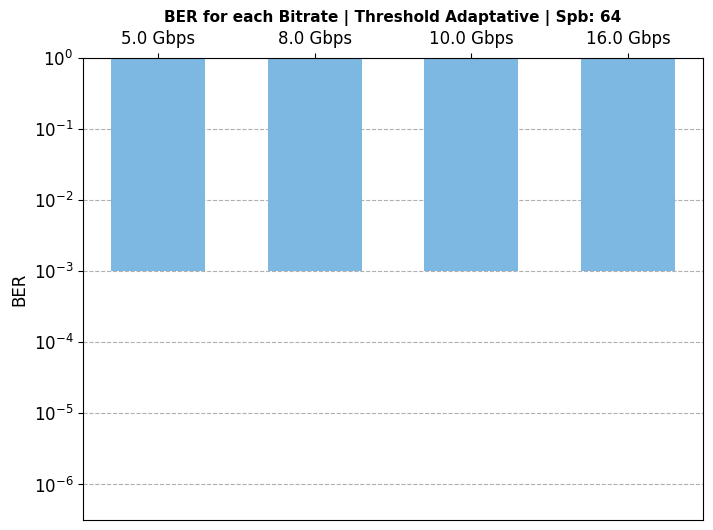

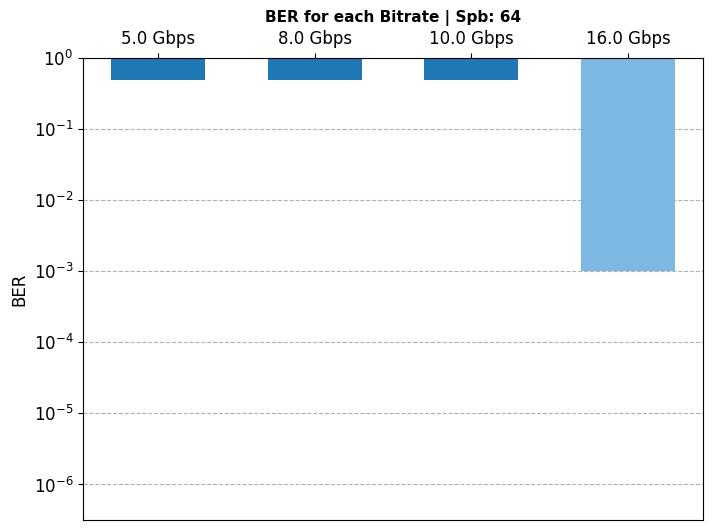

In [13]:
# Adaptative Threshold and Samp. position Plotting --------------------------------------------

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
colorArray = ['#1f77b4' if x == 0 else '#7CB8E1' for x in LimitReached[:,0]]

dxArray = {}
for i in range(len(Bitrates)): dxArray[f'{Bitrates[i]*1e-9} Gbps'] = i+1

fig, ax = plt.subplots()
ax.set_xticks(list(dxArray.values()), labels=dxArray.keys())
ax.yaxis.set_major_formatter(StrMethodFormatter('$10^{{{x:.0f}}}$'))
ax.set_ylim([-6.5, -0])
ax.bar(np.arange(len(Bitrates))+1 , np.log10(GeneralminBER[:,0]), zorder=2, width=0.6, color=colorArray)
ax.grid(True,linestyle='--',axis='y',zorder=1)
ax.set_ylabel('BER')
# ax.set_title(f'BER for each Bitrate | Threshold Adaptative | Lowest SNR: {np.round(np.min(SNRValue),2)} | Spb: {samplespBit}',fontweight="bold",fontsize=11)
ax.set_title(f'BER for each Bitrate | Threshold Adaptative | Spb: {samplespBit}',fontweight="bold",fontsize=11)

# datapath = '../../../data/Media/PNN_Results/ParallelModel/Post_Optimization/BER_Bitrates'
# file_count = sum(len(files) for _, _, files in os.walk(datapath))
# plt.savefig(datapath+"/"+"Bitrates_BER_Adaptative("+str(file_count)+").png", transparent=False, facecolor="white", bbox_inches="tight")
# plt.close()


# Optimal Constant Threshold and Samp. position Plotting --------------------------------------------

colorArrayOpt = ['#1f77b4' if x == 0 else '#7CB8E1' for x in LimitReached[:,1]]

fig, ax = plt.subplots()
ax.set_xticks(list(dxArray.values()), labels=dxArray.keys())
ax.yaxis.set_major_formatter(StrMethodFormatter('$10^{{{x:.0f}}}$'))
ax.set_ylim([-6.5, -0])
ax.bar(np.arange(len(Bitrates))+1 , np.log10(GeneralminBER[:,1]), zorder=2, width=0.6, color=colorArrayOpt)
ax.grid(True,linestyle='--',axis='y',zorder=1)
ax.set_ylabel('BER')
# ax.set_title(f'BER for each Bitrate | Lowest SNR: {np.round(np.min(SNRValue),2)} | Spb: {samplespBit}',fontweight="bold",fontsize=11)
ax.set_title(f'BER for each Bitrate | Spb: {samplespBit}',fontweight="bold",fontsize=11)

# datapath = '../../../data/Media/PNN_Results/ParallelModel/Post_Optimization/BER_Bitrates'
# file_count = sum(len(files) for _, _, files in os.walk(datapath))
# plt.savefig(datapath+"/"+"Bitrates_BER_OptConstant("+str(file_count)+").png", transparent=False, facecolor="white", bbox_inches="tight")
# plt.close()

j: 0


NameError: name 'sampOutArray' is not defined

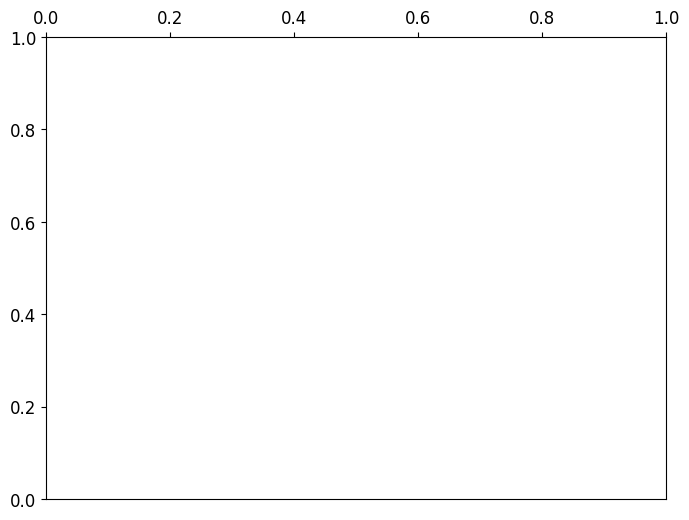

In [14]:
for j in range(len(minIdxArray)):
    print(f'j: {j}')
    fig, ax = plt.subplots()
    sampOut = sampOutArray[int(np.sum(minIdxArray[:j])) : int(np.sum(minIdxArray[:j+1]))]
    sampRef = sampRefArray[int(np.sum(minIdxArray[:j])) : int(np.sum(minIdxArray[:j+1]))]
    OscSignal = OSCSignalArray[int(np.sum(minIdxArray[:j])*samplespBit) : int(np.sum(minIdxArray[:j+1])*samplespBit)]
    OscTime = OSCTimeArray[int(np.sum(minIdxArray[:j])*samplespBit) : int(np.sum(minIdxArray[:j+1])*samplespBit)]
    print(f'lens: sampOut({len(sampOut)}) | sampRef({len(sampRef)}) | OscSignal({len(OscSignal)}) | OscTime({len(OscTime)})')

    maxvalue = np.max(OscSignal)
    OscSignal = OscSignal/maxvalue
    sampOut = sampOut/maxvalue
    # TimeAdjust = 1e12*j*(OptimalSampPos-1)/(Bitrates[j]*samplespBit)  # Ajusting time delay caused sampling position on output signal graph

    sampOut = sampOut[ : int(len(OscTime[::samplespBit]))]
    sampRef = sampRef[ : int(len(OscTime[::samplespBit]))]

    fig.set_figheight(4)
    fig.set_figwidth(18)
    ax.plot(OscTime*1e12 ,OscSignal,label='Out signal',linestyle='--',color='red',zorder=3)
    ax.plot(OscTime[:-samplespBit+1:samplespBit]*1e12,sampOut,'o',label='Samp. positions',color='red',zorder=4)
    ax.step(OscTime[:-samplespBit+1:samplespBit]*1e12,sampRef,'-o',label='Reference',color='gray',where='post',alpha=0.6,zorder=2)
    ax.hlines(y=OptimalThreshold/maxvalue,xmin=0,xmax=1e5,label='Opt. Threshold',linestyle='--',color='black')
    ax.set_xlim([4000, 4000 + 17*1e12/Bitrates[j]])
    ax.set_ylim([-0.1, 1.1])
    ax.grid(True,linestyle='--',axis='y',zorder=1)
    ax.set_ylabel('Normalized Amplitude')
    ax.set_xlabel('Time (ps)')
    # ax.set_title(f'Time Trace Graph | Lowest SNR: {np.round(np.min(SNRValue),2)} | Spb: {samplespBit} |  Bitrate: {Bitrates[j]*1e-9} Gbps',fontweight="bold",fontsize=11)
    ax.set_title(f'Time Trace Graph | Spb: {samplespBit} |  Bitrate: {Bitrates[j]*1e-9} Gbps',fontweight="bold",fontsize=11)
    ax.legend(loc='center right',fontsize=11)

### Graphs

In [1]:
OptBER = {
    '16 Gbps': [-0.3, -0.3, -0.6, -4.6],
    '10 Gbps': [-0.58, -0.52, -4.3, -0.6],
    '8 Gbps':  [-0.58, -4.98, -2.63, -0.91],
    '5 Gbps':  [-4.49, -0.3, -0.3, -0.9]
}

AdapBER = {
    '16 Gbps': [-5, -5, -5, -5],
    '10 Gbps': [-5, -5, -4.99, -0.75],
    '8 Gbps':  [-5, -5, -3.52, -3.18],
    '5 Gbps':  [-5, -5, -5, -5]
}

In [ ]:
bitratesX = ['5 Gbps', '8 Gbps', '10 Gbps', '16 Gbps']

def cor_const(val):
    return '#1f77b4' if val > -5 else '#7CB8E1' 

def cor_adap(val):
    return "#FFB469" if val > -5 else "#FFE2B6"

for train in OptBER.keys():
    opt_vals = OptBER[train]
    adap_vals = AdapBER[train]
    
    x = np.arange(len(bitratesX))
    width = 0.4

    colors_const = [cor_const(val) for val in opt_vals]
    colors_adap = [cor_adap(val) for val in adap_vals]

    fig, ax = plt.subplots(figsize=(7, 4.5))

    ax.grid(True, linestyle='--', axis='y', zorder=0)

    desloc = width / 2.5

    ax.bar(x - desloc, opt_vals, width=width, 
           color=colors_const, edgecolor='black', linewidth=0.5, 
           label='Optimal constant', zorder=2)

    ax.bar(x + desloc, adap_vals, width=width/2, 
           color=colors_adap, edgecolor='black', linewidth=0.5, 
           label='Adaptative', zorder=2)

    ax.set_xticks(x)
    ax.set_xticklabels(bitratesX)
    ax.yaxis.set_major_formatter(StrMethodFormatter('$10^{{{x:.0f}}}$'))
    ax.set_ylim([-6.1, 0])
    ax.set_ylabel('BER (log10)')
    ax.set_title(f'BER for each bitrate | Trained in {train}', fontweight="bold", fontsize=12)
    ax.legend(handles=[
        plt.Rectangle((0,0),1,1, color='#1f77b4', label='Optimal constant'),
        plt.Rectangle((0,0),1,1, color="#FFB469", label='Adaptative')
    ], fontsize=10)
    
    plt.show()

C:\Users\Caio\AppData\Local\Temp\ipykernel_10804\535510417.py:42: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0,0),1,1, color='#1f77b4', label='Optimal constant', edgecolor='black', linewidth=0.5),
C:\Users\Caio\AppData\Local\Temp\ipykernel_10804\535510417.py:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0,0),1,1, color='#CB69FF', label='Adaptative', edgecolor='black', linewidth=0.5)


✅ Gráfico salvo como 'BER_Subplots_2x2.pdf'


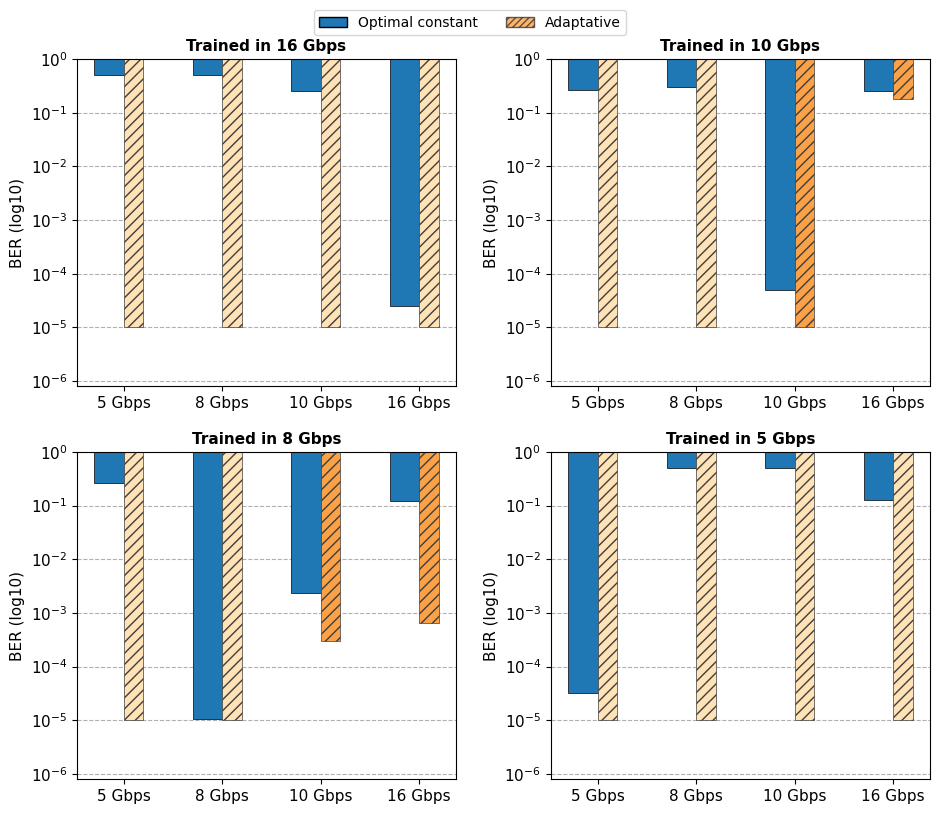

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import StrMethodFormatter
import matplotlib.patches as mpatches

labels = ['a)', 'b)', 'c)', 'd)'] 
bitratesX = ['5 Gbps', '8 Gbps', '10 Gbps', '16 Gbps']

def cor_const(val):
    return '#1f77b4' if val > -5 else '#7CB8E1'

def cor_adap(val):
    return "#FBA148" if val > -5 else "#FFE2B6"

def hatch_def(val):
    return "///" if val > -5 else ".."

fig, axes = plt.subplots(2, 2, figsize=(9.5, 9))
axes = axes.flatten()

width = 0.55 
desloc = width / 4 

for idx, train in enumerate(OptBER.keys()):
    ax = axes[idx]
    opt_vals = OptBER[train]
    adap_vals = AdapBER[train]
    
    x = np.arange(len(bitratesX))

    colors_const = [cor_const(val) for val in opt_vals]
    colors_adap = [cor_adap(val) for val in adap_vals]
    hatch_adap = [hatch_def(val) for val in adap_vals]

    ax.grid(True, linestyle='--', axis='y', zorder=0)

    ax.bar(x - desloc, opt_vals, width=width, 
           color=colors_const, edgecolor='black', linewidth=0.5, 
           label='Optimal constant', zorder=2)

    ax.bar(x + desloc, adap_vals, width=width * 0.5, 
        color=colors_adap, edgecolor='#3E3E3E', linewidth=0.5, 
        hatch=hatch_adap, 
        label='Adaptative', zorder=2)

    ax.set_xticks(x)
    ax.set_xticklabels(bitratesX, rotation=35)
    ax.yaxis.set_major_formatter(StrMethodFormatter('$10^{{{x:.0f}}}$'))
    ax.set_ylim([-5.5, 0])
    # ax.set_title(f'Trained in {train}', fontweight="bold", fontsize=11)
    ax.set_ylabel('BER (log10)',  fontsize=15)
    ax.tick_params(axis='both', labelsize=17)

    ax.text(0.03, 0.1, labels[idx], transform=ax.transAxes,
        fontsize=18, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.22)

const_patch = mpatches.Patch(facecolor='#1f77b4', edgecolor='black', label='Optimal constant')
adap_patch = mpatches.Patch(facecolor="#FC9732", edgecolor="#232323", hatch='///', alpha=0.7, label='Adaptative')
adap2_patch = mpatches.Patch(facecolor="#FFE2B6", edgecolor="#232323", hatch='..', alpha=0.7, label='Adaptative (Statistical Limit)')

fig.legend(handles=[const_patch, adap_patch, adap2_patch],
           loc='upper center', ncol=3, fontsize=15, bbox_to_anchor=(0.5, 1.02))

plt.subplots_adjust(top=0.94,hspace=0.35,wspace=0.4)

plt.savefig('BER_Comparison_Subplots.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [21]:
LoadCheckpoint = 3
picklepath = '../../../data/Checkpoints/PNN_Results/ParallelModel/AgentParallel_Simulating/'
with open(picklepath + f'Checkpoint({LoadCheckpoint}).pickle', 'rb') as handle:
    LoadFile = pickle.load(handle)
sampOutArray = LoadFile['sampOut']
sampRefArray = LoadFile['sampRef']
OSCSignalArray = LoadFile['OscSignal']
OSCTimeArray = LoadFile['OscTime']

In [25]:
print(len(sampRefArray))
print(len(sampOutArray))
print(minIdxArray)

3936
3936
[984. 984. 984. 984.]


j: 0
lens: sampOut(984) | sampRef(984) | OscSignal(62976) | OscTime(62976)
j: 1
lens: sampOut(984) | sampRef(984) | OscSignal(62976) | OscTime(62976)
j: 2
lens: sampOut(984) | sampRef(984) | OscSignal(62976) | OscTime(62976)
j: 3
lens: sampOut(984) | sampRef(984) | OscSignal(62976) | OscTime(62976)


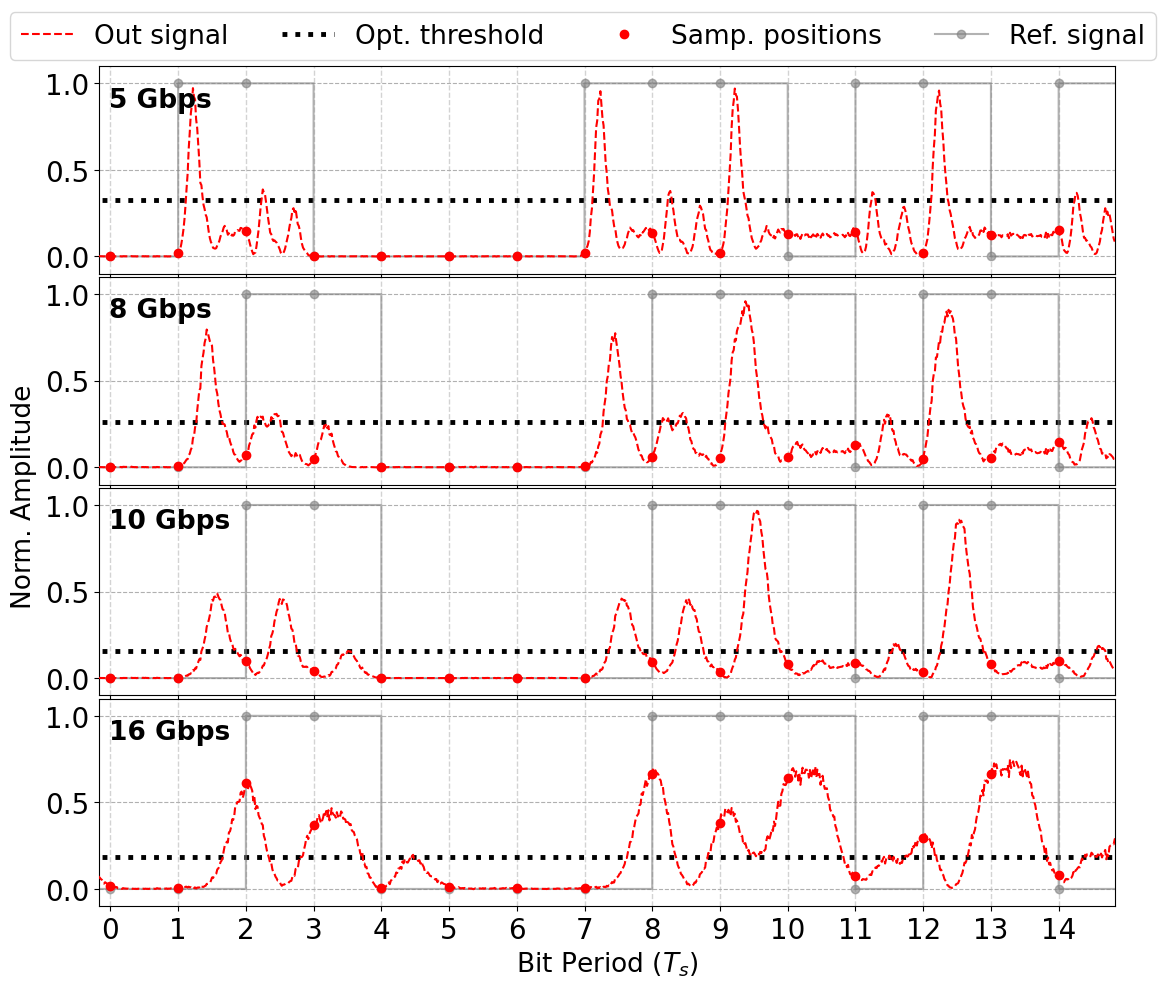

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(4, 1, figsize=(11, 10), sharex=False)

labels = ['5 Gbps', '8 Gbps', '10 Gbps', '16 Gbps'] 

for j, ax in enumerate(axes):
    print(f'j: {j}')
    
    sampOut = sampOutArray[int(np.sum(minIdxArray[:j])) : int(np.sum(minIdxArray[:j+1]))]
    sampRef = sampRefArray[int(np.sum(minIdxArray[:j])) : int(np.sum(minIdxArray[:j+1]))]
    OscSignal = OSCSignalArray[int(np.sum(minIdxArray[:j])*samplespBit) : int(np.sum(minIdxArray[:j+1])*samplespBit)]
    OscTime = OSCTimeArray[int(np.sum(minIdxArray[:j])*samplespBit) : int(np.sum(minIdxArray[:j+1])*samplespBit)]

    # sampOut = sampOutArray
    # sampRef = sampRefArray
    # OscSignal = OSCSignalArray
    # OscTime = OSCTimeArray

    print(f'lens: sampOut({len(sampOut)}) | sampRef({len(sampRef)}) | OscSignal({len(OscSignal)}) | OscTime({len(OscTime)})')

    maxvalue = np.max(OscSignal)
    OscSignal = OscSignal / maxvalue
    sampOut = sampOut / maxvalue

    sampOut = sampOut[: int(len(OscTime[::samplespBit]))]
    sampRef = sampRef[: int(len(OscTime[::samplespBit]))]

    ax.plot(OscTime * 1e12, OscSignal, linestyle='--', color='red', zorder=3,linewidth=1.5)
    # ax.plot(OscTime[:-samplespBit+1:samplespBit] * 1e12, sampOut, 'o', color='red', zorder=4)
    # ax.step(OscTime[:-samplespBit+1:samplespBit] * 1e12, sampRef, '-o', color='gray', where='post', alpha=0.6, zorder=2)
    ax.hlines(y=OptimalThreshold / maxvalue, xmin=0, xmax=1e5, linestyle='dotted', color='black',linewidth=3.5)

    ax.plot(OscTime[:-samplespBit+1:samplespBit] * 1e12, sampOut, 'o', color='red', zorder=4)
    ax.step(OscTime[:-samplespBit+1:samplespBit] * 1e12, sampRef, '-o', color='gray', where='post', alpha=0.6, zorder=2)

    xtick_positions = OscTime[:-samplespBit+1:samplespBit] * 1e12
    xtick_labels = list(range(1-13, len(xtick_positions)+1-13))

    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels)

    # Linhas verticais nos ticks
    for xtick in xtick_positions:
        ax.axvline(x=xtick, color='lightgray', linestyle='--', linewidth=1, zorder=0)

    # ax.set_xlim([4800 , 4800 + 13 * 1e12 / Bitrates[j]])
    ax.set_xlim([20e12 / Bitrates[j] ,35e12 / Bitrates[j]])
    ax.set_ylim([-0.1, 1.1])
    ax.grid(True, linestyle='--', axis='y', zorder=1)
    # ax.set_ylabel('Norm. Amplitude', fontsize=19)
    if(j == 3):
        ax.set_xlabel('Bit Period ($T_s$)', fontsize=19)
    # ax.set_title(f'Time Trace | Spb: {samplespBit} | Bitrate: {Bitrates[j]*1e-9:.1f} Gbps', fontweight="bold", fontsize=12)
    
    # Aumentar tamanho dos ticks
    ax.tick_params(axis='x', which='both', top=False, bottom=True, labelsize=20)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelsize=20)
    ax.xaxis.set_tick_params(labeltop=False, labelbottom=True)

    ax.text(0.01, 0.9, labels[j], transform=ax.transAxes,
        fontsize=19, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.subplots_adjust(top=0.93, left=0.06, hspace=0.015)

fig.text(-0.02, 0.5, 'Norm. Amplitude', va='center', rotation='vertical', fontsize=19)
fig.legend(['Out signal', 'Opt. threshold', 'Samp. positions', 'Ref. signal'], 
           loc='upper center', ncol=4, fontsize=19)

plt.savefig('TimeTrace_Subplots.pdf', format='pdf', bbox_inches='tight')

plt.show()
